# OpenCV 로 RANSAC 실습하기

- 실습예제 https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html
- 참고자료
    1. [ORB 관련자료](https://076923.github.io/posts/Python-opencv-38)
    2. [RANSAC 관련자료](https://deep-learning-study.tistory.com/262)
    3. [OpenCV 공식 홈페이지 참고자료](https://docs.opencv.org/4.x/d1/de0/tutorial_py_feature_homography.htmlhttps://docs.opencv.org/4.x/d1/de0/tutorial_py_feature_homography.html)

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

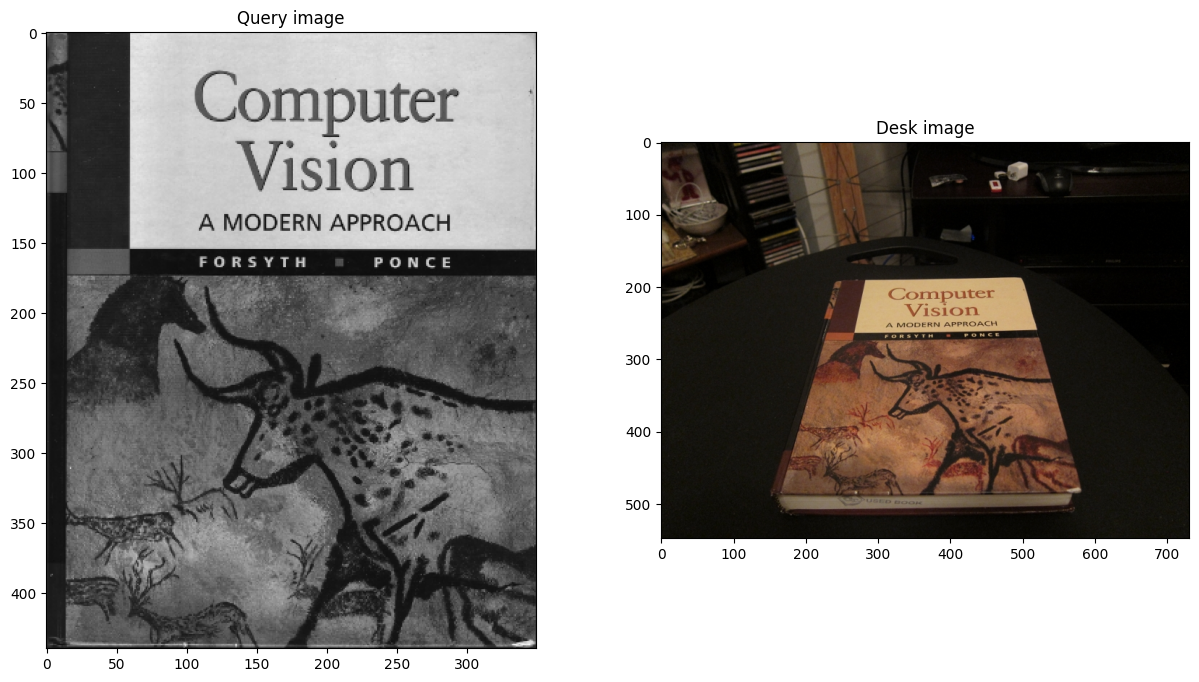

In [3]:
queryImage= 'data/cv_cover.jpg' # 책 이미지
trainImage='data/cv_desk.png' # 전체 이미지

plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.imshow(cv.cvtColor(cv.imread(queryImage), cv.COLOR_BGR2RGB))
plt.title('Query image')
plt.subplot(1,2,2)
plt.imshow(cv.cvtColor(cv.imread(trainImage), cv.COLOR_BGR2RGB))
plt.title('Desk image')
plt.show()

In [4]:
img1 = cv.imread(queryImage,cv.IMREAD_GRAYSCALE)         
img2 = cv.imread(trainImage,cv.IMREAD_GRAYSCALE)

## detector

* ORB 로 이전에 학습한 내용과 같습니다.

In [5]:
orb = cv.ORB_create()

In [6]:
# ORB로 keypoint, descriptors 생성
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

In [7]:
# 전수 조사 매칭(Brute force matching) 유효 거리가 짧을수록 우수한 매칭
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# 매치 함수(orb.match)로 최적의 매칭을 검출합니다. 거리 값이 낮을수록 매칭이 정확합니다.
matches = bf.match(des1,des2)
# 거리값이 낮은순으로 sort
matches = sorted(matches, key = lambda x:x.distance)

for match in matches[:10]:
    print(match.distance)

17.0
19.0
29.0
29.0
31.0
32.0
34.0
34.0
35.0
35.0


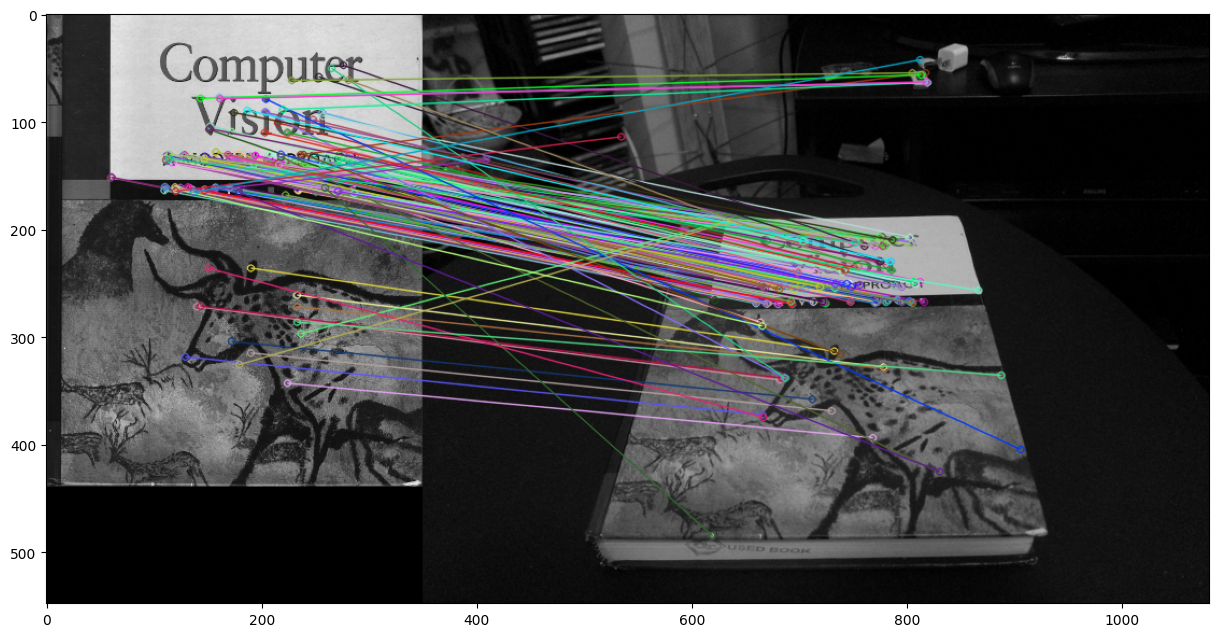

In [8]:
# 매칭끼리 시각화
img3 = cv.drawMatches(img1,kp1,img2,kp2,matches,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(15,8))
plt.imshow(img3)
plt.show()

* outlier가 꽤 많이 생성됩니다. 

## Find homography and warping with RANSAC

호모그래피(Homography)는 두 평면 사이의 투시 변환(Perspective transform)을 의미합니다.

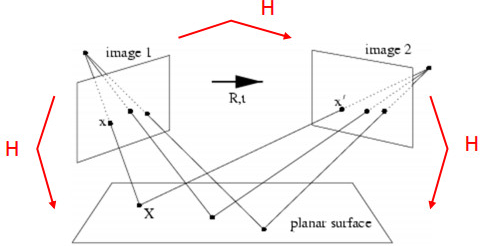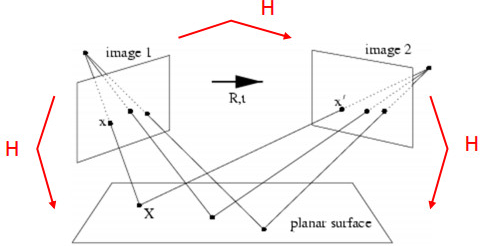


In [9]:
# Extract location of good matches
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

points1.shape, points2.shape

((144, 2), (144, 2))

In [ ]:
for i, match in enumerate(matches):
    points1[i, :] = kp1[match.queryIdx].pt
    points2[i, :] = kp2[match.trainIdx].pt

In [10]:
## cv의 findhomography
h, mask = cv.findHomography(points1, points2, cv.RANSAC)

cv2.findHomography(srcPoints, dstPoints, method=None, ransacReprojThreshold=None, mask=None, maxIters=None, confidence=None) -> retval, mask</br>
• srcPoints: 1번 이미지 특징점 좌표. numpy.ndarray. shape=(N, 1, 2). dtype=numpy.float32.</br>
• dstPoints: 2번 이미지 특징점 점 좌표. numpy.ndarray. shape=(N, 1, 2). dtype=numpy.float32.</br>
• method: 호모그래피 행렬 계산 방법. 0, LMEDS, RANSAC, RHO 중 선택. 기본값은 0이며, 이상치가 있을 경우 RANSAC, RHO 방법 권장.</br>
• ransacReprojThreshold: RANSAC 재투영 에러 허용치. 기본값은 3.</br>
• maxIters: RANSAC 최대 반복 횟수. 기본값은 2000.</br>
• retval: 호모그래피 행렬. numpy.ndarray. shape=(3, 3). dtype=numpy.float32.</br>
• mask: 출력 마스크 행렬. RANSAC, RHO 방법 사용 시 Inlier로 사용된 점들을 1로 표시한 행렬. numpy.ndarray. shape=(N, 1), dtype=uint8

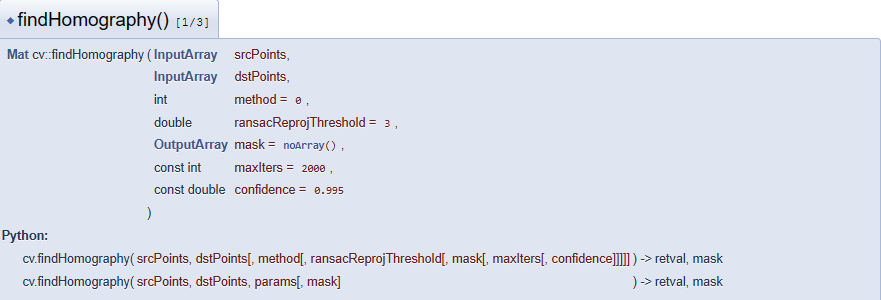
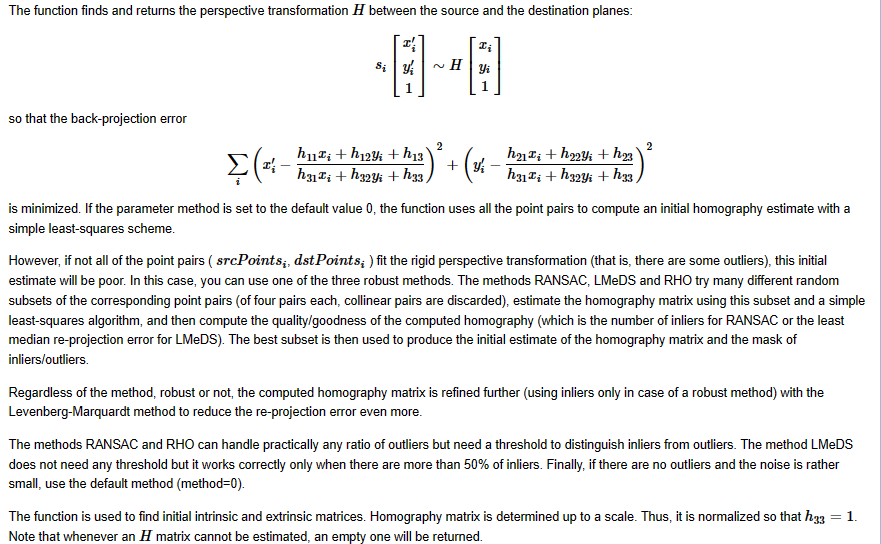

In [11]:
height, width = img2.shape

im1_warped = cv.warpPerspective(img1, h, (width, height))

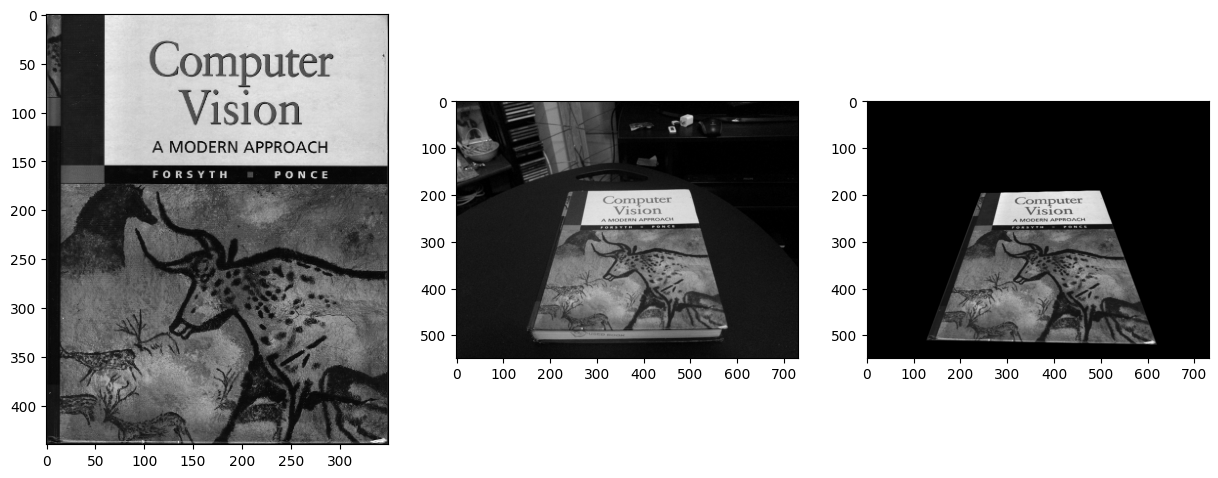

In [12]:
plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
plt.imshow(img1, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(img2, cmap='gray')
plt.subplot(1,3,3)
plt.imshow(im1_warped, cmap='gray')
plt.show()

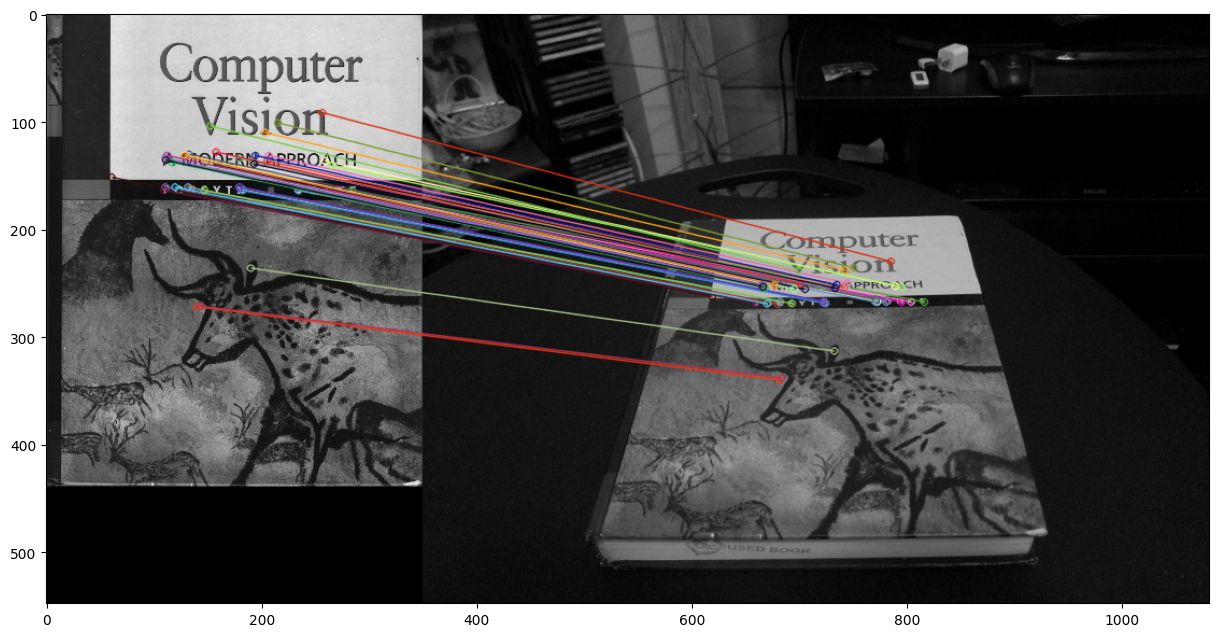

In [13]:
matches_opencv_ransac = np.array(matches)[np.nonzero(mask.squeeze())]
img3 = cv.drawMatches(img1,kp1,img2,kp2, matches_opencv_ransac ,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15,8))
plt.imshow(img3)
plt.show()

# Kornia로 RANSAC 실습하기

* 참고자료 - [Kornia RANSAC](https://kornia.readthedocs.io/en/latest/geometry.ransac.html?highlight=ransac)

이전에 detector 로 찾아둔 matches와 point는 그대로 사용합니다.

tensor([[ 6.6441e-01, -4.6078e-01,  2.4622e+02],
        [-2.7783e-02,  1.0017e-01,  1.9819e+02],
        [-7.7615e-05, -1.2525e-03,  1.0000e+00]])
torch.Size([144]) (144, 2) (144, 2)


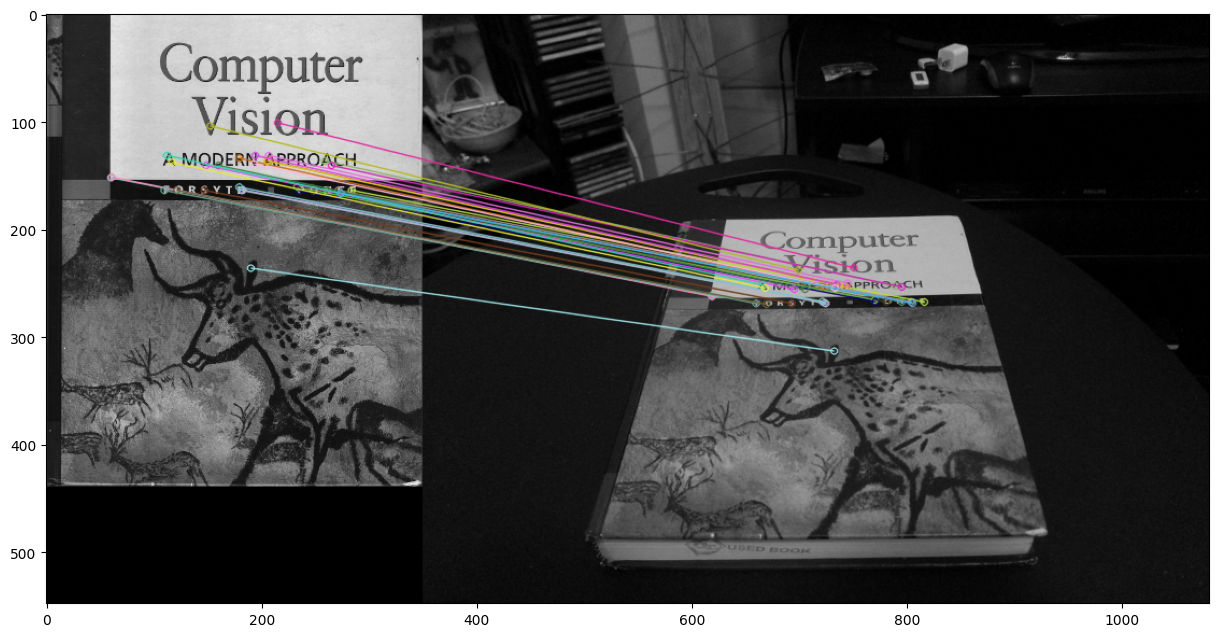

In [14]:
import torch
import kornia.geometry as KG
ransac = KG.ransac.RANSAC(model_type='homography')

# print(points1, points2, points1.shape)
H, inliers = ransac(torch.tensor(points1), torch.tensor(points2))

print(H)

print(inliers.shape, points1.shape, points2.shape)

matches_kornia = np.array(matches)[np.nonzero(inliers.squeeze())][:, 0]


img3 = cv.drawMatches(img1,kp1,img2,kp2,matches_kornia,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15,8))
plt.imshow(img3)
plt.show()

tensor([[ 1.0250e-05,  1.1989e-03, -1.6001e-01],
        [-2.0436e-03,  8.5398e-05,  1.8363e-01],
        [ 5.1125e-01, -3.7523e-01,  1.0000e+00]])


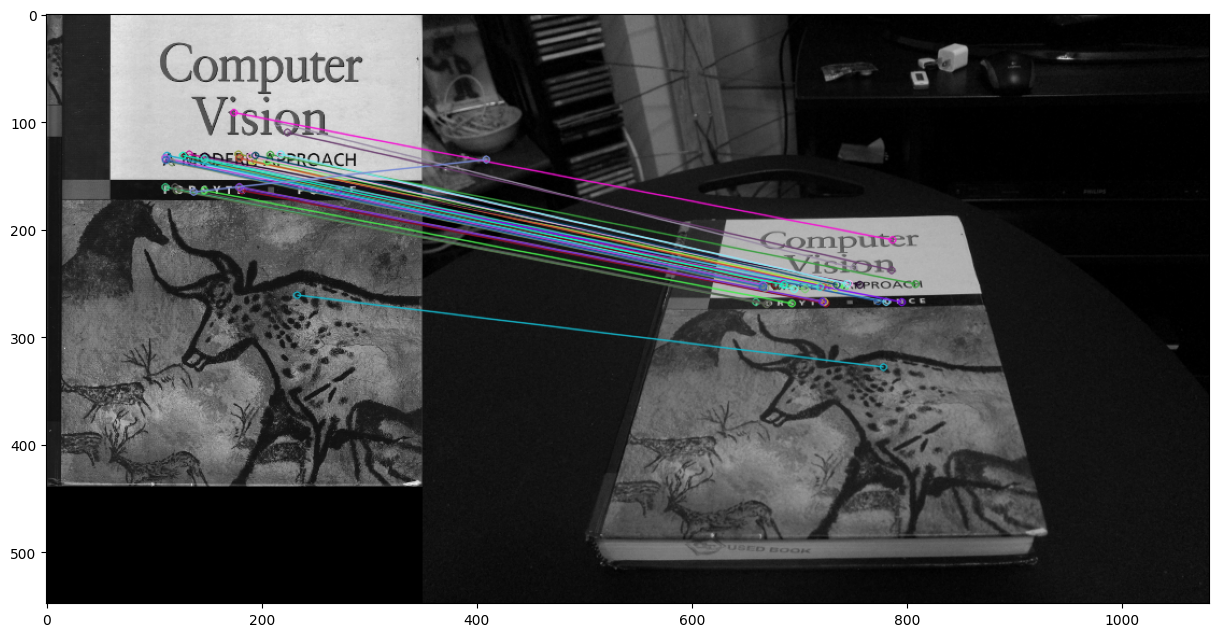

In [15]:
ransac = KG.ransac.RANSAC(model_type='fundamental')
F, inliers = ransac(torch.tensor(points1), torch.tensor(points2))

print(F)  ## fundamental matrix
matches_kornia = np.array(matches)[np.nonzero(inliers.squeeze())][:, 0]


img3 = cv.drawMatches(img1,kp1,img2,kp2,matches_kornia,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15,8))
plt.imshow(img3)
plt.show()

# DEGENSAC ( 심화 )

현재 random consensus 계열의 여러 outlier rejection & model fitting 알고리즘에 비해 좋은 성능이라 알려져 있음.

- Github - https://github.com/ducha-aiki/pydegensac

- PAPER
    1. [Locally Optimized RANSAC](https://cmp.felk.cvut.cz/~chum/papers/chum-DAGM03.pdf)
    2. [DEGENSAC](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.466.2719&rep=rep1&type=pdf)
    3. [비교 실험 논문](https://arxiv.org/pdf/2003.01587.pdf)
    
![](https://github.com/ducha-aiki/pydegensac/blob/master/img/ransacs.png?raw=true)

In [18]:
#pip install pydegensac

In [19]:
import pydegensac

[[ 1.67139800e+00 -8.01833272e-01  5.55030750e+02]
 [-6.58912429e-02  5.28768540e-01  4.48494242e+02]
 [-1.61925209e-04 -2.09953480e-03  2.32066167e+00]]
(144,) (144, 2) (144, 2)



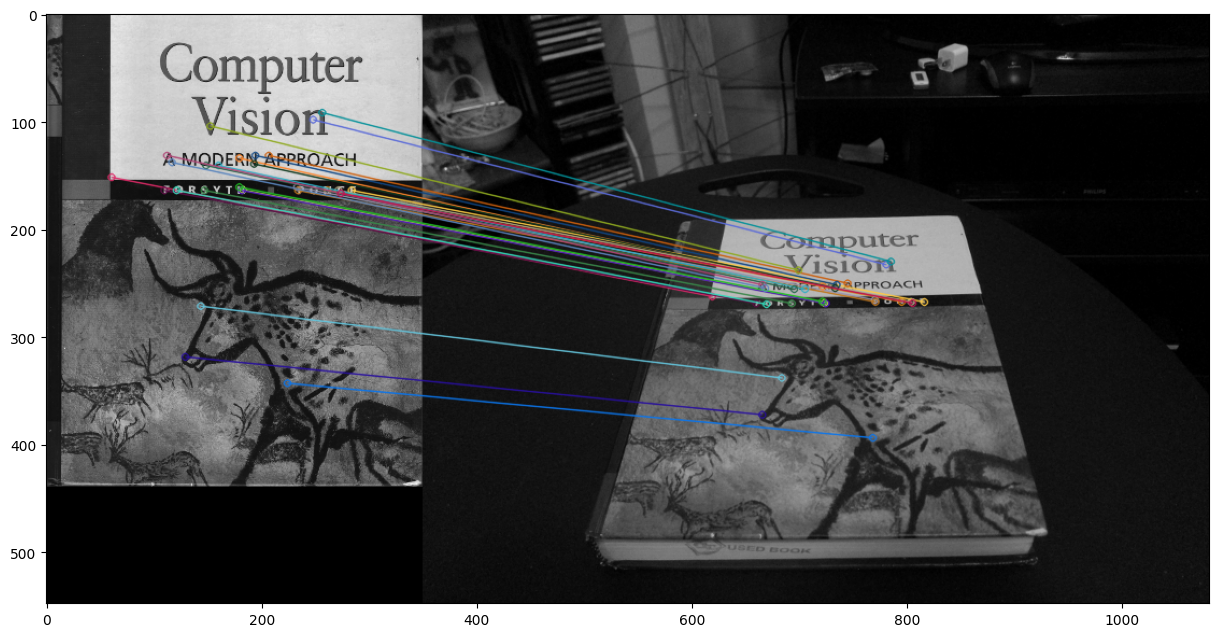

In [20]:
H, inliers = pydegensac.findHomography(np.array(points1), np.array(points2))

print(H)

print(inliers.shape, points1.shape, points2.shape)
print()
inlier_idx= np.nonzero(inliers.squeeze())
matches_degensac = np.array(matches)[inlier_idx]


img3 = cv.drawMatches(img1,kp1,img2,kp2,matches_degensac,None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(15,8))
plt.imshow(img3)
plt.show()